## Portfolio Exam Part 2
This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers. <br>

Attribute Information: <br>

InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. <br>
StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. <br>
Description: Product (item) name. Nominal. <br>
Quantity: The quantities of each product (item) per transaction. Numeric. <br>
InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. <br>
UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). <br>
CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. <br>
Country: Country name. Nominal. The name of the country where a customer resides. <br>

In [3]:
#Load Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from imp import reload
from sklearn.cluster import DBSCAN
from functools import reduce

## Data Cleansing
Looking for missing values

In [48]:
# Import Dataset
df1 = pd.read_excel('online_retail_II.xlsx', sheet_name = 0)
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name = 1)
df = pd.concat([df1,df2], axis=0)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [50]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [51]:
df.shape

(1067371, 8)

In the following, the data set is examined for missing values. It can be seen that there are missing values for the Description and Customer ID features. <br>
For the feature Description, 0.41% of the values are missing. This is to be considered very low and, in my view, can be seen as a missing entry in the product database. <br>
For the Customer ID feature, 22.7% of all invoices do not have a customer ID. This leads to booking errors because no customer can be assigned to the invoice. <br>
For further consideration of the data, the data must be removed.

In [52]:
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

Invoice         0.00
StockCode       0.00
Description     0.41
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.77
Country         0.00
dtype: float64

In [46]:
customerID = df["Customer ID"].isnull()
customerID_ = df[customerID]
customerID_

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cost Per Invoice
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom,-0.00
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom,-0.00
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom,-0.00
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom,-0.00
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,0.55
...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom,20.65
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom,16.52
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom,4.96
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom,10.79


In [47]:
quantity = df['Quantity'] < 0
quantity_ = df[quantity]
quantity_

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cost Per Invoice
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.40
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,-9.90
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,-17.00
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,-12.60
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.40
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25


When examining the item price, it is noticeable that certain items do not have a commodity price. <br> 
These calculations can lead to erroneous assumptions in further use. For this purpose, all invoices that have a price of 0 Sterling per item are removed.

In [66]:
price = df['Price'] == 0
price_ = df[price]
price_.head()
print(price_.shape)
price_1 = price_["StockCode"].unique()
price_1
check = df[df["StockCode"].isin(price_1)]["Price"] == 0
check.value_counts()

(6202, 8)


False    599316
True       6202
Name: Price, dtype: int64

In [67]:
price = df['Price'] != 0
price_ = df[price]
print(price_.head())
df_null_price = round(100*(price_.isnull().sum())/len(price_), 2)
print(df_null_price)
df.dropna(inplace = True)

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
Invoice         0.00
StockCode       0.00
Description     0.00
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.32
Country         0.00
dtype: float64


In [68]:
df.shape

(824364, 8)

Checking Outliers

In [69]:
mask = df["Quantity"] > 0
df = df[mask]
df.shape

(805620, 8)

In [70]:
q = df["Price"].quantile(0.99)
q

14.95

## Data Exploration

Explore the data. Looking for most seeling items, customers, countries...

In [74]:
df['Cost Per Invoice'] = df['Quantity'] * df['Price']

C:\Users\wuest\AppData\Local\Temp/ipykernel_23836/3818036792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cost Per Invoice'] = df['Quantity'] * df['Price']


In [75]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cost Per Invoice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [112]:
df['year'] = df['InvoiceDate'].dt.year
df['month'] = df['InvoiceDate'].dt.month
df['weekday'] = df['InvoiceDate'].dt.weekday
df['hour'] = df['InvoiceDate'].dt.hour

In [113]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cost Per Invoice,year,month,weekday,hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,1,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,1,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,1,7


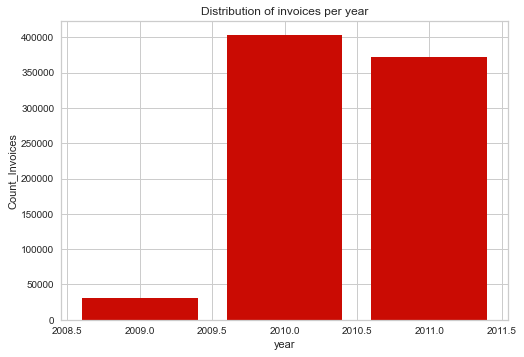

In [116]:
year = df.groupby("year", as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
fig, ax = plt.subplots()
rects1 = ax.bar(year["year"], year["Count_Invoices"], color='r')
 
# Bar Plot
ax.set_ylabel('Count_Invoices')
ax.set_xlabel('year')
ax.set_title('Distribution of invoices per year')
# Show Plot
plt.show()

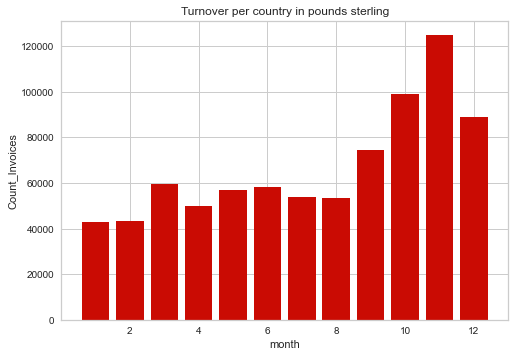

In [109]:
month = df.groupby("month", as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
month.head()
fig, ax = plt.subplots()
rects1 = ax.bar(month["month"], month["Count_Invoices"], color='r')
# Bar Plot
ax.set_ylabel('Count_Invoices')
ax.set_xlabel('month')
ax.set_title('Distribution of invoices per month')
# Show Plot
plt.show() 

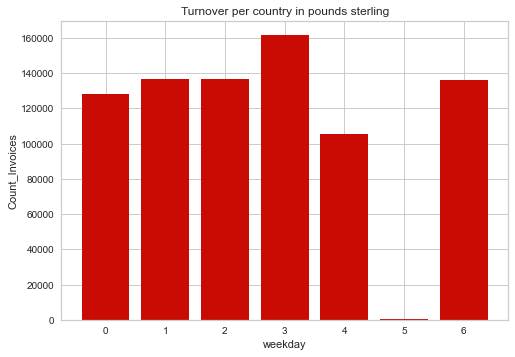

In [111]:
weekday = df.groupby("weekday", as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
weekday.head()
fig, ax = plt.subplots()
rects1 = ax.bar(weekday["weekday"], weekday["Count_Invoices"], color='r')
# Bar Plot
ax.set_ylabel('Count_Invoices')
ax.set_xlabel('weekday')
ax.set_title('Distribution of invoices per weekday')
# Show Plot
plt.show() 

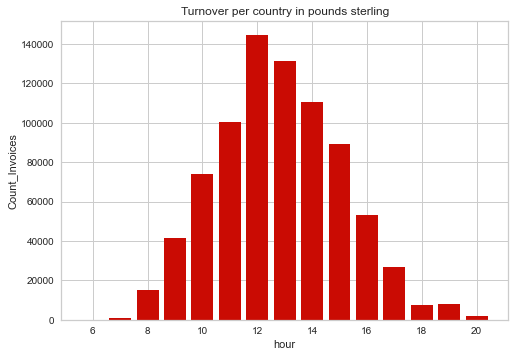

In [115]:
hour = df.groupby("hour", as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
hour.head()
fig, ax = plt.subplots()
rects1 = ax.bar(hour["hour"], hour["Count_Invoices"], color='r')
# Bar Plot
ax.set_ylabel('Count_Invoices')
ax.set_xlabel('hour')
ax.set_title('Distribution of invoices per hour')
# Show Plot
plt.show() 

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(top_ten_countries["Country"], top_ten_countries["Cost Per Invoice"], color='r')
 
# Horizontal Bar Plot
ax.set_ylabel('Countries')
ax.set_xlabel('Turnover in pounds sterling')
ax.set_title('Turnover per country in pounds sterling')
# Show Plot
plt.show()

In [24]:
top_ten_countries = df.groupby("Country", as_index= False)["Cost Per Invoice"].agg('sum').sort_values(by = "Cost Per Invoice",ascending= False).head(10)
top_ten_countries

,Country,Cost Per Invoice
38,United Kingdom,1.472315e+07
10,EIRE,6.216311e+05
24,Netherlands,5.542323e+05
14,Germany,4.312625e+05
13,France,3.552575e+05
0,Australia,1.699681e+05
32,Spain,1.091785e+05
34,Switzerland,1.003653e+05
33,Sweden,9.154972e+04
9,Denmark,6.986219e+04


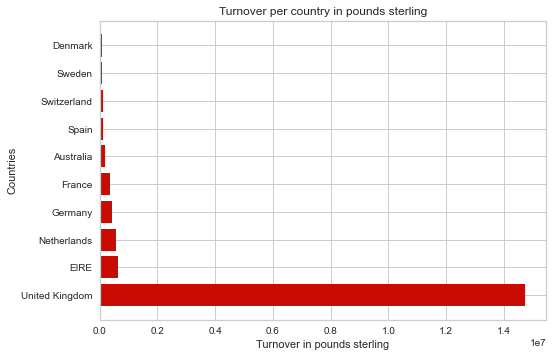

In [25]:
# Figure Size
fig, ax = plt.subplots()
rects1 = ax.barh(top_ten_countries["Country"], top_ten_countries["Cost Per Invoice"], color='r')
 
# Horizontal Bar Plot
ax.set_ylabel('Countries')
ax.set_xlabel('Turnover in pounds sterling')
ax.set_title('Turnover per country in pounds sterling')
# Show Plot
plt.show()

In [26]:
turnover_countries = df.groupby("Country", as_index= False)["Cost Per Invoice"].agg('sum').sort_values(by = "Cost Per Invoice",ascending= False)
turnover_countries["turnover_countries_percentage"] = round(100*(turnover_countries["Cost Per Invoice"])/sum(turnover_countries["Cost Per Invoice"]), 2)
turnover_countries.head(10)

,Country,Cost Per Invoice,turnover_countries_percentage
38,United Kingdom,1.472315e+07,82.98
10,EIRE,6.216311e+05,3.50
24,Netherlands,5.542323e+05,3.12
14,Germany,4.312625e+05,2.43
13,France,3.552575e+05,2.00
0,Australia,1.699681e+05,0.96
32,Spain,1.091785e+05,0.62
34,Switzerland,1.003653e+05,0.57
33,Sweden,9.154972e+04,0.52
9,Denmark,6.986219e+04,0.39


The most turnover is made in the UK with 82.93%. The online shop also has small turnovers in EIRE (Irland), Netherland, Germany and France. This countries come to a turnover of 11,21%. The rest 6% of the turnover is made around the world. 

In [27]:
lne = len(df["StockCode"].unique())

lne

4631

In [28]:
top_10_products = df.groupby(["StockCode","Description"], as_index= False).agg(Count_item=('Country', 'count')).sort_values(by = "Count_item",ascending=False)
top_10_products["count_product_percentage"] = round(100*(top_10_products["Count_item"])/sum(top_10_products["Count_item"]), 2)
top_10_products

,StockCode,Description,Count_item,count_product_percentage
4905,85123A,WHITE HANGING HEART T-LIGHT HOLDER,5181,0.64
1735,22423,REGENCY CAKESTAND 3 TIER,3430,0.43
3649,84879,ASSORTED COLOUR BIRD ORNAMENT,2777,0.34
4893,85099B,JUMBO BAG RED RETROSPOT,2702,0.34
378,21034,REX CASH+CARRY JUMBO SHOPPER,2141,0.27
...,...,...,...,...
2303,22880,"NUMBER TILE VINTAGE FONT, 1",1,0.00
2305,22881,"NUMBER TILE VINTAGE FONT, 2",1,0.00
2307,22882,"NUMBER TILE VINTAGE FONT, 3",1,0.00
2309,22883,"NUMBER TILE VINTAGE FONT, 4",1,0.00


In [29]:
result = top_10_products["count_product_percentage"] > 0
result.count()

5315

In [30]:
print("The Onlineshop has "+ str(len(df["StockCode"].unique()))+ " different products.")

The Onlineshop has 4631 different products.


In [31]:
top_10_customer = df.groupby("Customer ID", as_index= False).agg(Count_item=('Cost Per Invoice', 'sum')).sort_values(by = "Count_item",ascending=False)
top_10_customer["count_customer_percentage"] = round(100*(top_10_customer["Count_item"])/sum(top_10_customer["Count_item"]), 2)
top_10_customer

,Customer ID,Count_item,count_customer_percentage
5695,18102.0,608821.65,3.43
2279,14646.0,528602.52,2.98
1791,14156.0,313946.37,1.77
2541,14911.0,295972.63,1.67
5053,17450.0,246973.09,1.39
...,...,...,...
4351,16738.0,3.75,0.00
1731,14095.0,2.95,0.00
904,13256.0,0.00,0.00
1739,14103.0,0.00,0.00


In [32]:
print("The Onlineshop has "+ str(len(df["Customer ID"].unique()))+ " different Customers.")

The Onlineshop has 5881 different Customers.


## Motivation

After the Data Expolration we found out that the most turnover is made in the UK. Also we saw that the store has 4646 different products and 

In [72]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [78]:
df_a = df.groupby(["Invoice","Customer ID", "InvoiceDate"], as_index= False).agg(Items = ("StockCode","nunique"), Amount_of_Products= ("Quantity", "sum"),Total_Price=("Cost Per Invoice","sum"))
#df_a1 = df_a.drop(["Invoice","Customer ID"], axis = 1)

In [79]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37039 entries, 0 to 37038
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Invoice             37039 non-null  int64         
 1   Customer ID         37039 non-null  float64       
 2   InvoiceDate         37039 non-null  datetime64[ns]
 3   Items               37039 non-null  int64         
 4   Amount_of_Products  37039 non-null  int64         
 5   Total_Price         37039 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 1.7 MB


In [82]:
df_a.sort_values(by = "InvoiceDate", ascending= True).head()

,Invoice,Customer ID,InvoiceDate,Items,Amount_of_Products,Total_Price
0,489434,13085.0,2009-12-01 07:45:00,8,166,505.30
1,489435,13085.0,2009-12-01 07:46:00,4,60,145.80
2,489436,13078.0,2009-12-01 09:06:00,19,193,630.33
3,489437,15362.0,2009-12-01 09:08:00,23,145,310.75
4,489438,18102.0,2009-12-01 09:24:00,17,826,2286.24


In [118]:
df_recency = df_a.groupby(by='Customer ID',
                        as_index=False)['InvoiceDate'].max()
df_recency.columns = ['Customer ID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,Customer ID,LastPurchaseDate,Recency
0,12346.0,2011-01-18 10:01:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


In [121]:
frequency_df = df_a.drop_duplicates().groupby(
    by=['Customer ID'], as_index=False)['InvoiceDate'].count()
frequency_df.columns = ['Customer ID', 'Frequency']
frequency_df.head()

,Customer ID,Frequency
0,12346.0,12
1,12347.0,8
2,12348.0,5
3,12349.0,4
4,12350.0,1


In [122]:
monetary_df = df_a.groupby(by='Customer ID', as_index=False)['Total_Price'].sum()
monetary_df.columns = ['Customer ID', 'Monetary']
monetary_df.head()

,Customer ID,Monetary
0,12346.0,77556.46
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4428.69
4,12350.0,334.40


In [127]:
all_df = [df_recency,frequency_df,monetary_df]
rfm_df = reduce(lambda left,right: pd.merge(left,right,on='Customer ID'), all_df)

In [130]:
rfm_df_data = rfm_df[["Recency",'Frequency','Monetary']]

K-Means Clustering

In [35]:
def calculate_silhouette_score(k_min,k_max,df):
    silhouettes=[]
    i = k_min
    for i in range(k_min,k_max+1):   
        kmeans=KMeans(n_clusters=i, random_state=1) # <- by default, this runs k-means++, starting over 10 times, reporting the best result
        y_pred = kmeans.fit_predict(df)
        print(silhouette_score(df,y_pred))
        silhouettes.append(silhouette_score(df,y_pred))
    return kmeans,silhouettes

In [36]:
def plot_silhouette_score(k_min,k_max,silhouette):
    reload(plt)
    plt.xlabel('k')
    plt.ylabel('Silhouette Coefficient')
    plt.plot(range(k_min,k_max+1), silhouette)
    plt.legend()
    return plt.show()

0.9867248403366821
0.9763912139316827
0.91574217552423
0.8973794079069982
0.8272749154492925
0.7580764201546475
0.699122098513843
0.7020666941776249
0.6907759196837356


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


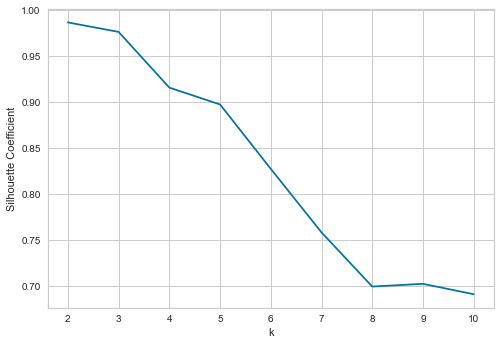

In [131]:
k_min = 2
k_max = 10
kmeans,silhouette = calculate_silhouette_score(k_min,k_max,rfm_df_data)
plot_silhouette_score(k_min,k_max,silhouette)

In [38]:
def plot_clusters_with_centers(kmeans, X, index_x, index_y):
    plt.figure(figsize=(8, 8))
    y_pred = kmeans.fit_predict(X)
    print(len(np.unique(y_pred)))
    for i in range(0,len(np.unique(y_pred))):
        plt.scatter(X.iloc[y_pred==i, index_x], X.iloc[y_pred==i, index_y], c=colors[i], label=i, marker = '.')

    plt.xlabel("Num_reactions")
    plt.ylabel("Num_likes")
    plt.scatter(
        kmeans.cluster_centers_[:, index_x], 
        kmeans.cluster_centers_[:, index_y],
        s=350, marker='*', c='green', edgecolor='black'
    )
    plt.legend()
    

In [1]:
colors=['blue', 'darkorange','red', 'orange','black','green']
kmeans,silhouette = calculate_silhouette_score(4,4,rfm_df_data)
plot_clusters_with_centers(kmeans, rfm_df_data, 1, 2)

NameError: name 'calculate_silhouette_score' is not defined

In [138]:
print(kmeans)
labels_2=kmeans.predict(rfm_df_data)
test = pd.DataFrame()
test['cluster2'] = labels_2
distribution = test['cluster2'].value_counts()
print(distribution)

KMeans(n_clusters=4, random_state=1)
0    5777
3      89
1      13
2       2
Name: cluster2, dtype: int64


In [2]:
def visualize_silhouette_score(kmeans,color,X):
    visualizer = SilhouetteVisualizer(kmeans, colors=color, is_fitted=True)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.finalize()
    print(visualizer.silhouette_samples_)
    print(f'Silhoutte score: {visualizer.silhouette_score_}')
    visualizer.poof(outpath="3.5_sil.jpg")
    return visualizer.show()        # Finalize and render the figure

In [136]:
#StandartScaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(df_a1)

0.9839103791870059
0.6507177669632748
0.6525812070322451
0.641940534330166
0.6415220646099548
0.5443430687174644
0.546734748741118
0.5021443000117475
0.5138499151102226


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


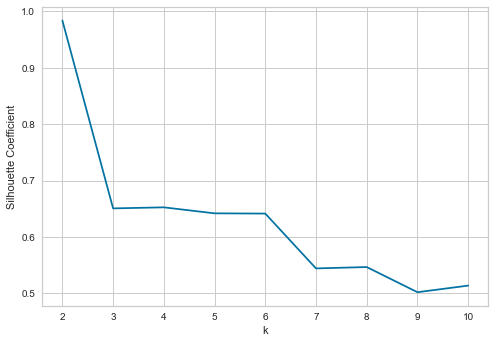

In [137]:
k_min = 2
k_max = 10
kmeans,silhouette = calculate_silhouette_score(k_min,k_max,scaled)
plot_silhouette_score(k_min,k_max,silhouette)

0.6507177669632748
3


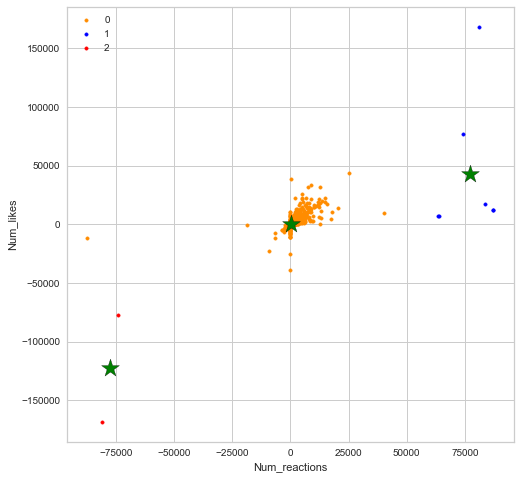

In [138]:
colors=['darkorange', 'blue','red', 'orange','black','green']
kmeans,silhouette = calculate_silhouette_score(3,3,scaled)
plot_clusters_with_centers(kmeans, df_a1, 1, 2)

In [143]:
print(kmeans)
labels_2=kmeans.predict(scaled)
test = pd.DataFrame()
test['cluster2'] = labels_2
distribution = test['cluster2'].value_counts()
print(distribution)


KMeans(n_clusters=3, random_state=1)
0    44876
Name: cluster2, dtype: int64


C:\Users\wuest\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Density Based Clustering

In [132]:
dbscan=DBSCAN(eps=1, min_samples=10, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=3)
dbscan_clusters=dbscan.fit_predict(df_a1)
print(np.unique(dbscan_clusters))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94
 95 96]


In [133]:
def plot_clusters(X, clusters):
    for cluster in np.unique(clusters):
        plt.scatter(X[clusters==cluster, 0], X[clusters==cluster, 1], c=colors[cluster])

In [134]:
colors=['darkorange', 'darkmagenta', 'dodgerblue', 'lightgreen', 'black']
plot_clusters(df_a1,dbscan_clusters)

TypeError: '(array([ True,  True,  True, ...,  True,  True, False]), 0)' is an invalid key